# Combining OpenCLSim and OpenTNSim

This notebook shows how to combine elements from OpenCLSim and OpenTNSim. You need OpenTNSim>=1.3.0 and OpenCLSim>=1.6 for this notebook to work. Since that version the core components (`Locatable`, `Identifiable`, `SimpyObject`) of opentnsim are referring to the versions from OpenCLSim. 

In this notebook we show how to use the "move" functionality of OpenTNSim with the activity workflow from OpenCLSim.
OpenCLSim does not allow sailing over graphs by default. On the other hand, OpenTNSim does not have the concept of activities.

In [1]:
import datetime
import time

import simpy
import pandas as pd
import shapely

import openclsim
import openclsim.model
import opentnsim
import networkx as nx

import pyproj

# Earth, to compute spherical distances
WGS84 = pyproj.Geod(ellps="WGS84")

# Create a simulation environment
This environment is shared between OpenCLSim & OpenTNSim through the `openclsim.core.SimpyObject`. 

In [2]:
simulation_start = 0
env = simpy.Environment(initial_time=simulation_start)

# Create sites and create a network

Here we'll combine the site (OpenCLSim) and graph (OpenTNSim) properties from both models. OpenTNSim has the concept of a graph, but does not use sites. We specify the site using OpenCLSim components. We create a route and graph using networkx and shapely as expected by OpenTNSim.


In [3]:
# create a Site object based on desired mixin classes
Site = type(
    "Site",
    (
        openclsim.core.Identifiable,
        openclsim.core.Log,
        openclsim.core.Locatable,
        openclsim.core.HasContainer,
        openclsim.core.HasResource,
    ),
    {},
)


## Create the points and geometries
In OpenTNSim nodes are points, you can sail over a linestring between points. Here we add an extra point in between the `location_from_site` and the `location_to_site`. That way you can sail more complex routes than just great circles. 

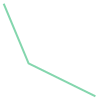

In [4]:
# prepare input data for from_site (note: in this example we only need the start location)
location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)

# prepare input data for to_site
location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)

# create a geometry in between
intermediate_point = shapely.geometry.Point(4.2, 52.14)

# Line of 3 points
edge_geometry =  shapely.geometry.LineString([location_from_site, intermediate_point, location_to_site])
edge_geometry

## Create the OpenCLSim sites
OpenCLSim ships always sail between sites. At each site it typically has to do something, like wait for a resource or fill a container. 

In [5]:
# The from site
data_from_site = {
    "env": env,
    "name": "from_site",
    "geometry": location_from_site,
    "capacity": 100,
    "level": 100,
}
# instantiate to_site 
from_site = Site(**data_from_site)

# We only need to define the to_site as an instance for OpenCLSim
data_to_site = {
    "env": env,
    "name": "to_site",
    "geometry": location_to_site,
    "capacity": 100,
    "level": 100,
}
# instantiate to_site 
to_site = Site(**data_to_site)

## Create the OpenTNSim graph
OpenTNSim has the concept of a graph. It sails between nodes, over edges. Each node and edge is expected to have a geometry. 

In [6]:
graph = nx.Graph()

# create a location based graph (with geometry as nodes)
graph.add_node(from_site.name, geometry=from_site.geometry)
graph.add_node(to_site.name, geometry=to_site.geometry)
graph.add_edge(from_site.name, to_site.name, geometry=edge_geometry)

env.graph = graph

## Define the vessel
Here we start to integrate OpenCLSim and OpenTNSim. We make a composed type of `Movable` and the OpenCLSim components that allow to move and transport goods (`HasContainer`, `Processor`). 

In [7]:

# create a TransportProcessingResource object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        opentnsim.core.Movable,
        openclsim.core.Identifiable,
        openclsim.core.Log,
        openclsim.core.HasResource,
        openclsim.core.HasContainer,
        openclsim.core.Processor,
        # capture extra metadata to make sure we don't have leftover arguments
        opentnsim.core.ExtraMetadata
    ),
    {},
)

## Instantiate the vessel
We can now make the vessel. Compared to a normal OpenCLSim route we have an extra `route` property.

In [8]:
# prepare input data for vessel_01
data_vessel01 = {
    "env": env,
    "name": "vessel-01",
    "geometry": location_from_site, 
    "capacity": 5,
    "v": 10,
    "route": [from_site.name, to_site.name]
}
# instantiate vessel 
vessel = TransportProcessingResource(**data_vessel01)
assert not vessel.metadata

## Setup the simulation
We can now have all the elements from the simulation. We can setup the regular OpenCLSim housekeeping.

In [9]:
# initialise registry
registry = {}

In [10]:
activity = openclsim.model.MoveActivity(
    env=env,
    name="Move activity",
    registry=registry,
    mover=vessel,
    destination=to_site,
)

In [11]:
# initate the simpy processes defined in the 'move activity' and run simpy
openclsim.model.register_processes([activity])
env.run()

## Show the results
We can now display how long it took.

In [12]:
display(openclsim.plot.get_log_dataframe(activity))

,Activity,Timestamp,ActivityState
0,6c3e62da-1229-42c1-b1da-035a7743920a,1970-01-01 00:00:00.000000,START
1,6c3e62da-1229-42c1-b1da-035a7743920a,1970-01-01 00:16:33.819868,STOP


In [13]:
# compute by hand to confirm the duration

distance = WGS84.geometry_length(edge_geometry)
datetime.datetime(1970, 1, 1) + datetime.timedelta(seconds=distance / vessel.v)

datetime.datetime(1970, 1, 1, 0, 16, 33, 819868)